<a href="https://colab.research.google.com/github/ajaykurani/DataAugmentation/blob/master/CNN_Testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torch
import torchvision
from torch import nn, optim
import torch.nn.functional as F
from torchvision import transforms
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
from scipy import ndimage
import seaborn as sns
import cv2
import math
import numbers
import random
from torchvision.utils import save_image
from torchsummary import summary
from google.colab import files

In [3]:
n_epochs = 20
batch_size_train = 64
batch_size_test = 1000
learning_rate = 1e-4
log_interval = 50

In [4]:
train_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.5,), (0.5,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.5,), (0.5,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

test_data = torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.Normalize(
                                 (0.5,), (0.5,))
                             ]))

train_loader_2 = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.RandomRotation(90),
                               torchvision.transforms.Normalize(
                                 (0.5,), (0.5,))
                             ])),
  batch_size=batch_size_train, shuffle=True)

test_loader_2 = torch.utils.data.DataLoader(
  torchvision.datasets.MNIST('/files/', train=False, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                               torchvision.transforms.RandomRotation(90),
                               torchvision.transforms.Normalize(
                                 (0.5,), (0.5,))
                             ])),
  batch_size=batch_size_test, shuffle=True)

Extracting /files/MNIST/raw/train-images-idx3-ubyte.gz to /files/MNIST/raw


Extracting /files/MNIST/raw/train-labels-idx1-ubyte.gz to /files/MNIST/raw


Extracting /files/MNIST/raw/t10k-images-idx3-ubyte.gz to /files/MNIST/raw


Extracting /files/MNIST/raw/t10k-labels-idx1-ubyte.gz to /files/MNIST/raw
Processing...
Done!


/usr/local/lib/python3.6/dist-packages/torchvision/datasets/mnist.py:480: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:141.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


### **Network Architecture**
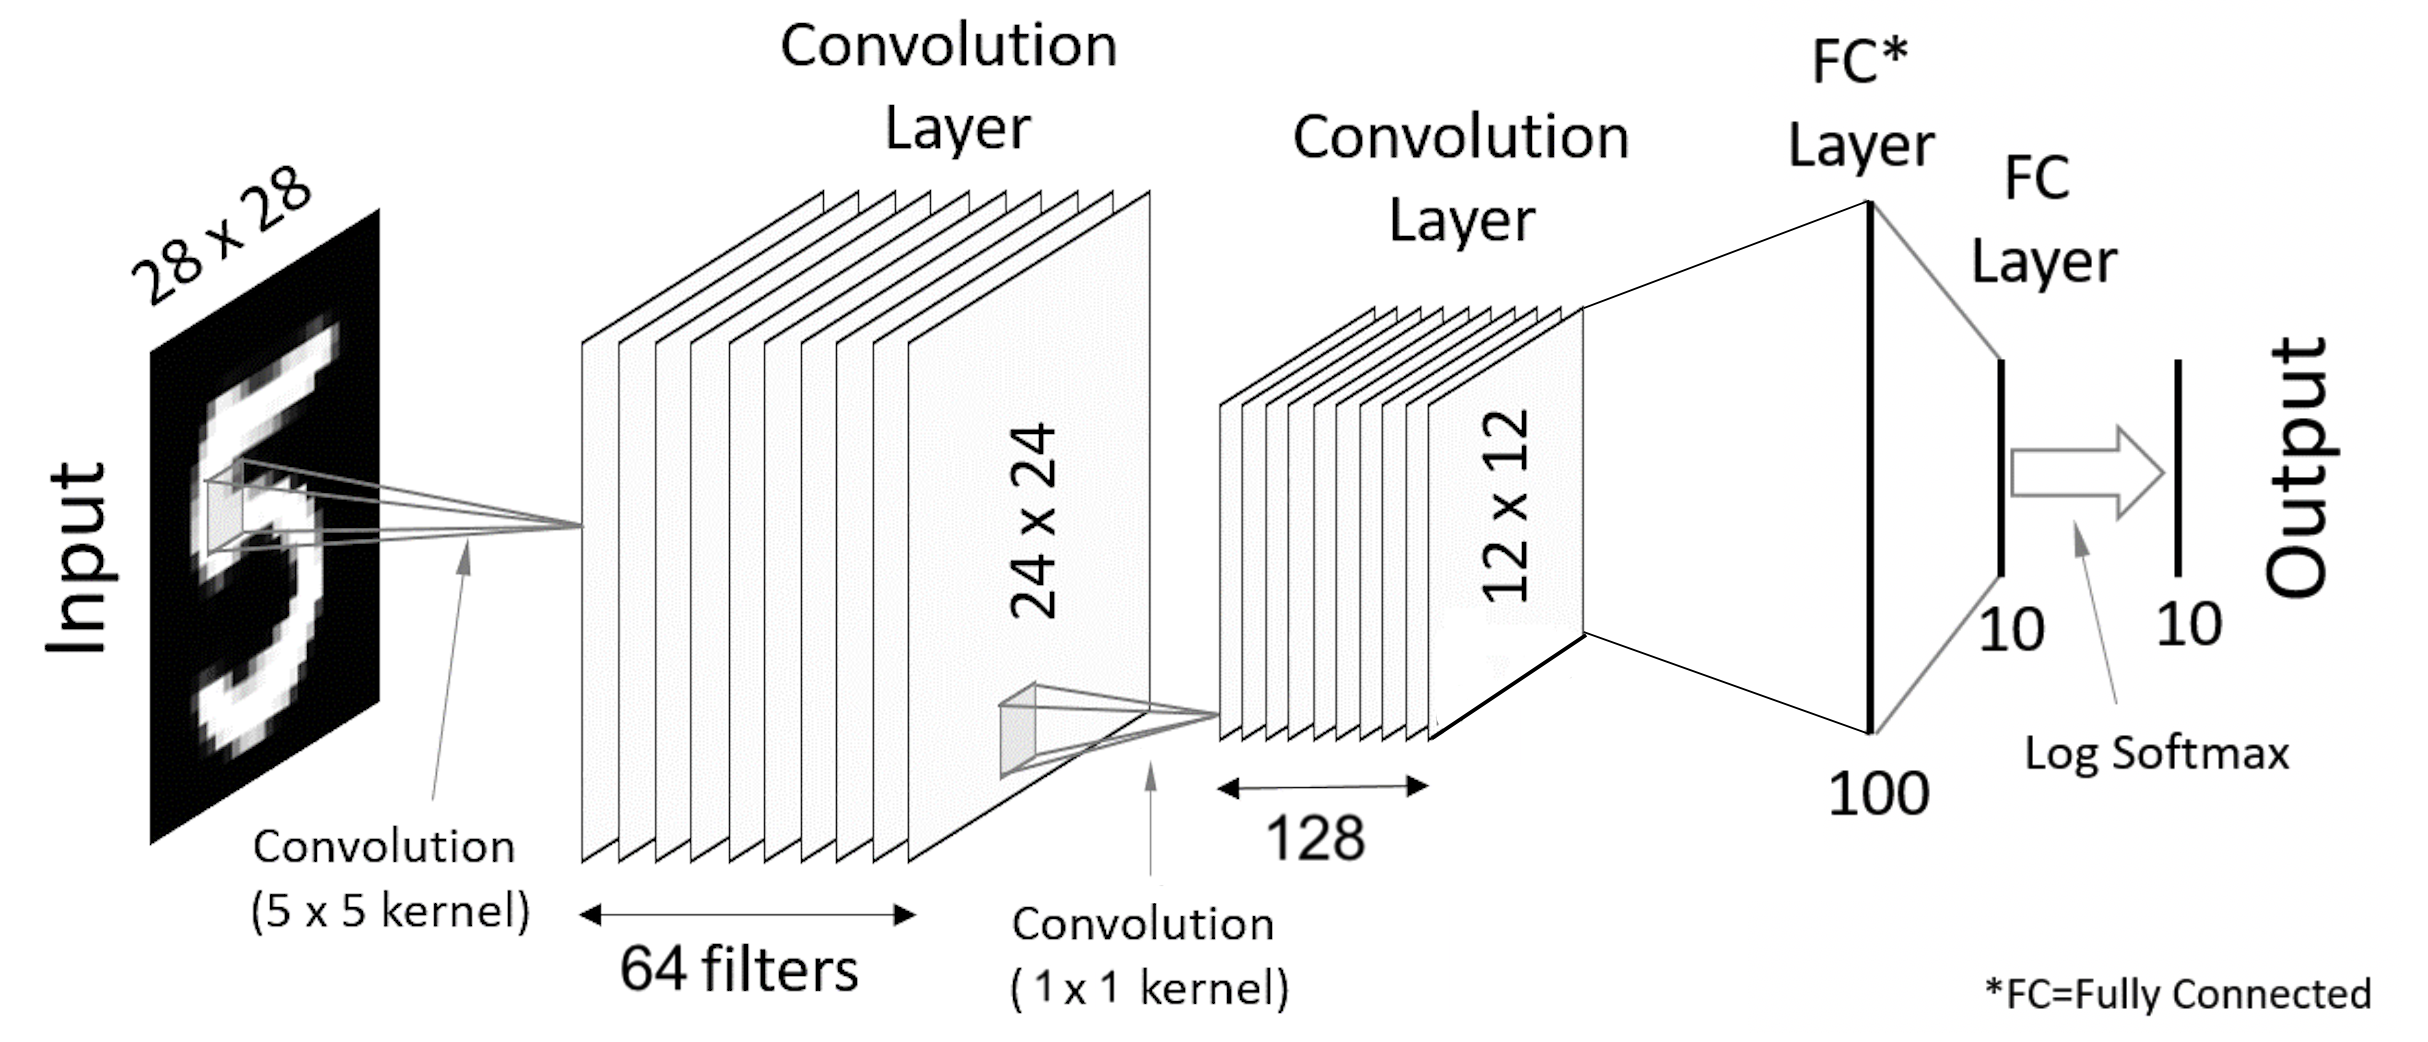

In [5]:
'''
Information on interpolation here: https://medium.com/@wenrudong/what-is-opencvs-inter-area-actually-doing-282a626a09b3
'''

class Net(nn.Module):
    '''
    Adapted from https://github.com/sksq96/pytorch-summary.
    More information on layers available here: https://towardsdatascience.com/pytorch-layer-dimensions-what-sizes-should-they-be-and-why-4265a41e01fd
    '''
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 64, kernel_size=5)
        self.conv2 = nn.Conv2d(64, 128, kernel_size=1)
        self.fc1 = nn.Linear(4608, 100)
        self.fc2 = nn.Linear(100, 10)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1(x), 2))
        x = F.relu(F.max_pool2d(self.conv2(x), 2))
        x = torch.flatten(x, start_dim=1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x
    
    def loss_function(self, out, target):
        return F.cross_entropy(out, target)

In [6]:
def init_weights(m):
    if type(m) == nn.Linear or type(m) == nn.Conv2d:
        torch.nn.init.xavier_uniform_(m.weight)
        m.bias.data.fill_(0.01)

network = Net()
network.apply(init_weights)
network.cuda()

optimizer = optim.Adam(network.parameters(), lr=1e-4)

summary(network, (1, 28, 28))



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 24, 24]           1,664
            Conv2d-2          [-1, 128, 12, 12]           8,320
            Linear-3                  [-1, 100]         460,900
            Linear-4                   [-1, 10]           1,010
Total params: 471,894
Trainable params: 471,894
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.42
Params size (MB): 1.80
Estimated Total Size (MB): 2.23
----------------------------------------------------------------


In [7]:
network2 = Net()
network2.apply(init_weights)
network2.cuda()
optimizer_2 = optim.Adam(network2.parameters(), lr=1e-4)
summary(network2, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 24, 24]           1,664
            Conv2d-2          [-1, 128, 12, 12]           8,320
            Linear-3                  [-1, 100]         460,900
            Linear-4                   [-1, 10]           1,010
Total params: 471,894
Trainable params: 471,894
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.42
Params size (MB): 1.80
Estimated Total Size (MB): 2.23
----------------------------------------------------------------


In [8]:
def train(epoch):
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    data = data.cuda()
    target = target.cuda()
    optimizer.zero_grad()
    output = network(data)
    loss = network.loss_function(output, target)
    loss.backward()
    optimizer.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))

In [9]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader:
      data = data.cuda()
      target = target.cuda()
      target = target.view(batch_size_test)
      output = network(data)
      test_loss += network.loss_function(output, target).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [10]:
def train2(epoch):
  network2.train()
  for batch_idx, (data, target) in enumerate(train_loader_2):
    data = data.cuda()
    target = target.cuda()
    optimizer_2.zero_grad()
    output = network2(data)
    loss = network2.loss_function(output, target)
    loss.backward()
    optimizer_2.step()
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader_2.dataset),
        100. * batch_idx / len(train_loader_2), loss.item()))

In [11]:
def test2():
  network2.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in test_loader_2:
      data = data.cuda()
      target = target.cuda()
      output = network2(data)
      test_loss += network2.loss_function(output, target).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader_2.dataset)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader_2.dataset),
    100. * correct / len(test_loader_2.dataset)))

In [12]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()


Test set: Avg. loss: 0.0023, Accuracy: 1206/10000 (12%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.291757
Train Epoch: 1 [3200/60000 (5%)]	Loss: 1.733861
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.014832
Train Epoch: 1 [9600/60000 (16%)]	Loss: 0.559536
Train Epoch: 1 [12800/60000 (21%)]	Loss: 0.439901
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.447834
Train Epoch: 1 [19200/60000 (32%)]	Loss: 0.273731
Train Epoch: 1 [22400/60000 (37%)]	Loss: 0.314683
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.245953
Train Epoch: 1 [28800/60000 (48%)]	Loss: 0.175906
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.156368
Train Epoch: 1 [35200/60000 (59%)]	Loss: 0.203522
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.145388
Train Epoch: 1 [41600/60000 (69%)]	Loss: 0.057296
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.279604
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.076151
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.155606
Train Epoch: 1 [54400/60000 (91%)]	Loss: 0.322955
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.277988



In [13]:
test2()
for epoch in range(1, n_epochs + 1):
  train2(epoch)
  test2()


Test set: Avg. loss: 0.0023, Accuracy: 754/10000 (8%)

Train Epoch: 1 [0/60000 (0%)]	Loss: 2.271330
Train Epoch: 1 [3200/60000 (5%)]	Loss: 2.154744
Train Epoch: 1 [6400/60000 (11%)]	Loss: 1.769193
Train Epoch: 1 [9600/60000 (16%)]	Loss: 1.360109
Train Epoch: 1 [12800/60000 (21%)]	Loss: 1.339962
Train Epoch: 1 [16000/60000 (27%)]	Loss: 0.940280
Train Epoch: 1 [19200/60000 (32%)]	Loss: 1.044026
Train Epoch: 1 [22400/60000 (37%)]	Loss: 0.755888
Train Epoch: 1 [25600/60000 (43%)]	Loss: 0.737194
Train Epoch: 1 [28800/60000 (48%)]	Loss: 0.849721
Train Epoch: 1 [32000/60000 (53%)]	Loss: 0.512979
Train Epoch: 1 [35200/60000 (59%)]	Loss: 0.799572
Train Epoch: 1 [38400/60000 (64%)]	Loss: 0.807199
Train Epoch: 1 [41600/60000 (69%)]	Loss: 0.695965
Train Epoch: 1 [44800/60000 (75%)]	Loss: 0.549737
Train Epoch: 1 [48000/60000 (80%)]	Loss: 0.485858
Train Epoch: 1 [51200/60000 (85%)]	Loss: 0.565523
Train Epoch: 1 [54400/60000 (91%)]	Loss: 0.510232
Train Epoch: 1 [57600/60000 (96%)]	Loss: 0.544498

Te

In [14]:
torch.save(network.state_dict(), 'network.pth')
torch.save(network2.state_dict(), 'network2.pth')
files.download('network.pth')
files.download('network2.pth')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

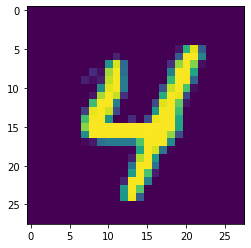

Prediction: 4


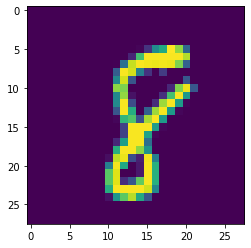

Prediction: 8


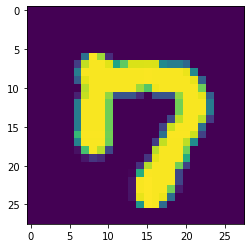

Prediction: 7


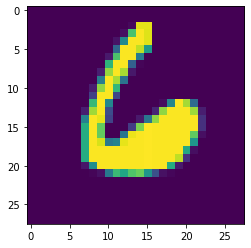

Prediction: 6


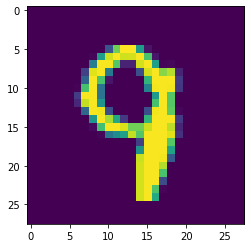

Prediction: 9


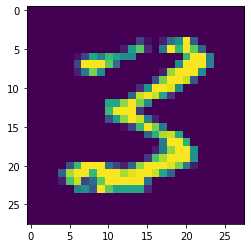

Prediction: 3


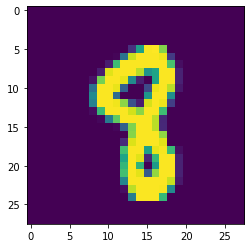

Prediction: 8


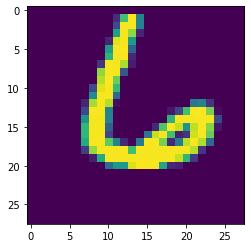

Prediction: 6


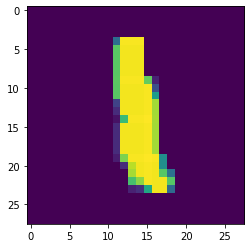

Prediction: 1


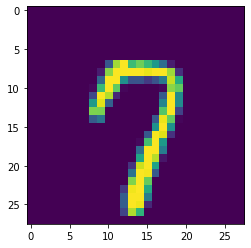

Prediction: 7


In [15]:
for data, target in test_loader:
  im = data[0]
  im = torch.squeeze(im)
  plt.imshow(im.numpy())
  plt.show()
  data = data.cuda()
  target = target.cuda()
  output = network(data)
  pred = output.data.max(1, keepdim=True)[1]
  print("Prediction: " + str(pred[0].item()))

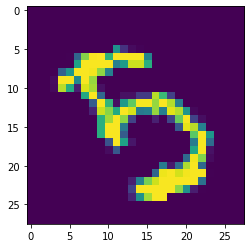

Prediction: 5


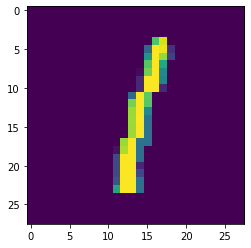

Prediction: 1


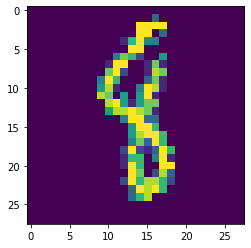

Prediction: 8


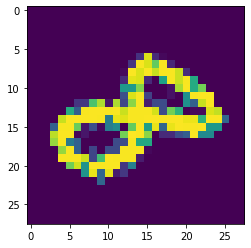

Prediction: 8


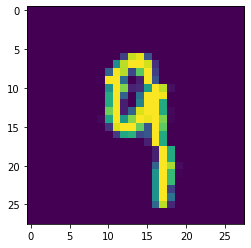

Prediction: 9


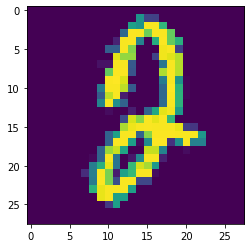

Prediction: 2


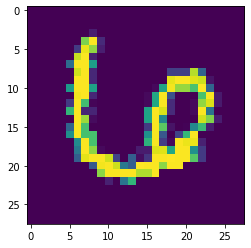

Prediction: 6


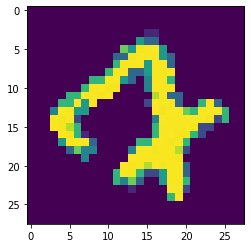

Prediction: 2


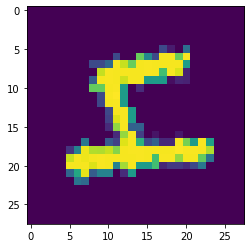

Prediction: 4


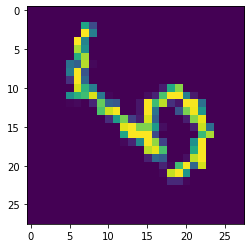

Prediction: 5


In [16]:
for data, target in test_loader_2:
  im = data[0]
  im = torch.squeeze(im)
  plt.imshow(im.numpy())
  plt.show()
  data = data.cuda()
  target = target.cuda()
  output = network2(data)
  pred = output.data.max(1, keepdim=True)[1]
  print("Prediction: " + str(pred[0].item()))

In [17]:
'''
Adapted from https://towardsdatascience.com/visualizing-convolution-neural-networks-using-pytorch-3dfa8443e74e.
More information on feature visualization: https://distill.pub/2017/feature-visualization/
'''

def imshow(img, title):
  std_correction = np.asarray([0.229, 0.224, 0.225]).reshape(3, 1, 1)
  mean_correction = np.asarray([0.485, 0.456, 0.406]).reshape(3, 1, 1)
  npimg = np.multiply(img.numpy(), std_correction) + mean_correction
  plt.figure(figsize = (batch_size * 4, 4))
  plt.axis("off")
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.title(title)
  plt.show()

def plot_filters_single_channel_big(t):
    
    #setting the rows and columns
    nrows = t.shape[0]*t.shape[2]
    ncols = t.shape[1]*t.shape[3]
    
    
    npimg = np.array(t.numpy(), np.float32)
    npimg = npimg.transpose((0, 2, 1, 3))
    npimg = npimg.ravel().reshape(nrows, ncols)
    
    npimg = npimg.T
    
    fig, ax = plt.subplots(figsize=(ncols/10, nrows/200))    
    imgplot = sns.heatmap(npimg, xticklabels=False, yticklabels=False, cmap='gray', ax=ax, cbar=False)
  
def plot_filters_single_channel(t):
    
    #kernels depth * number of kernels
    nplots = t.shape[0]*t.shape[1]
    ncols = 12
    
    nrows = 1 + nplots//ncols
    #convert tensor to numpy image
    npimg = np.array(t.numpy(), np.float32)
    
    count = 0
    fig = plt.figure(figsize=(ncols, nrows))
    
    #looping through all the kernels in each channel
    for i in range(t.shape[0]):
        for j in range(t.shape[1]):
            count += 1
            ax1 = fig.add_subplot(nrows, ncols, count)
            npimg = np.array(t[i, j].numpy(), np.float32)
            npimg = (npimg - np.mean(npimg)) / np.std(npimg)
            npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
            ax1.imshow(npimg)
            ax1.set_title(str(i))
            ax1.axis('off')
            ax1.set_xticklabels([])
            ax1.set_yticklabels([])
   
    plt.tight_layout()
    plt.show()

def plot_filters_multi_channel(t):
    
    #get the number of kernals
    num_kernels = t.shape[0]    
    
    #define number of columns for subplots
    num_cols = 12
    #rows = num of kernels
    num_rows = num_kernels
    
    #set the figure size
    fig = plt.figure(figsize=(num_cols,num_rows))
    
    #looping through all the kernels
    for i in range(t.shape[0]):
        ax1 = fig.add_subplot(num_rows,num_cols,i+1)
        
        #for each kernel, we convert the tensor to numpy 
        npimg = np.array(t[i].numpy(), np.float32)
        #standardize the numpy image
        npimg = (npimg - np.mean(npimg)) / np.std(npimg)
        npimg = np.minimum(1, np.maximum(0, (npimg + 0.5)))
        npimg = npimg.transpose((1, 2, 0))
        ax1.imshow(npimg)
        ax1.axis('off')
        ax1.set_title(str(i))
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])
        
    plt.savefig('myimage.png', dpi=100)    
    plt.tight_layout()
    plt.show()

def plot_weights(model, layer_num, single_channel = True, collated = False):
  #extracting the model features at the particular layer number
  if layer_num == 1:
    layer = model.conv1
  elif layer_num == 2:
    layer = model.conv2
  else:
    print("Convolutional layer not found")
    return
  
  #checking whether the layer is convolution layer or not 
  if isinstance(layer, nn.Conv2d):
    #getting the weight tensor data
    weight_tensor = layer.weight.data
    
    if single_channel:
      if collated:
        plot_filters_single_channel_big(weight_tensor)
      else:
        plot_filters_single_channel(weight_tensor)
        
    else:
      if weight_tensor.shape[1] == 3:
        plot_filters_multi_channel(weight_tensor)
      else:
        print("Can only plot weights with three channels with single channel = False")
        
  else:
    print("Can only visualize layers which are convolutional")

### **Convolutional Filter Visualizations**

In [18]:
# plot_weights(network.cpu(), 1, single_channel = True)

Convolutional Filters, Aligned Network, Layer 1


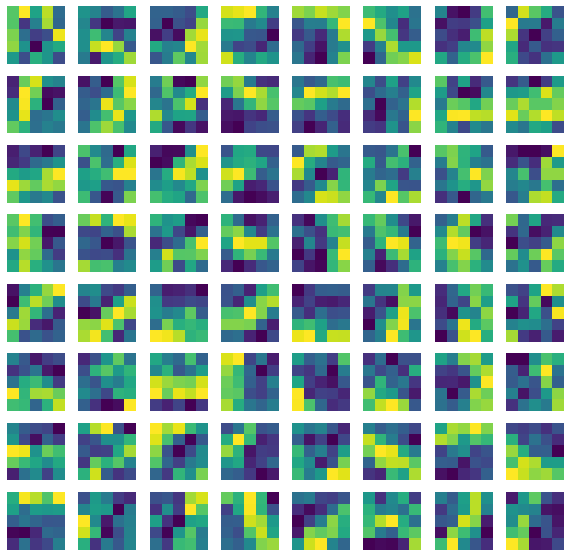

In [19]:
print("Convolutional Filters, Aligned Network, Layer 1")
plt.figure(figsize=(10, 10))
sq = 8
weight = network.conv1.weight.data.cpu().numpy()

for i in range(64):
    plt.subplot(sq, sq, i + 1)
    plt.imshow(weight[i][0], cmap='viridis')
    plt.axis("off")

plt.show()

Convolutional Filters, Rotated Network, Layer 1


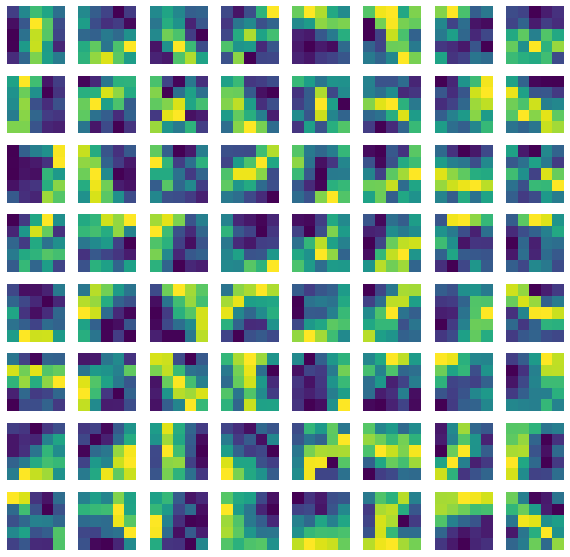

In [20]:
print("Convolutional Filters, Rotated Network, Layer 1")
plt.figure(figsize=(10, 10))
sq = 8
weight = network2.conv1.weight.data.cpu().numpy()

for i in range(64):
    plt.subplot(sq, sq, i + 1)
    plt.imshow(weight[i][0], cmap='viridis')
    plt.axis("off")

plt.show()

Convolutional Filters, Image Subtraction, Layer 1


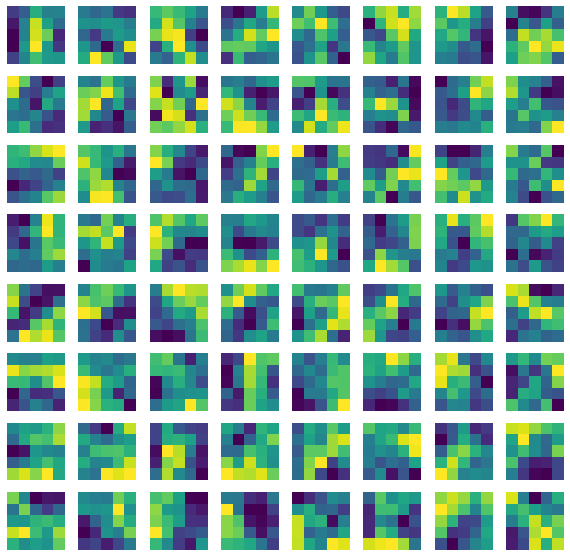

In [21]:
print("Convolutional Filters, Image Subtraction, Layer 1")
plt.figure(figsize=(10, 10))
sq = 8
weight = network.conv1.weight.data.cpu().numpy()
weight2 = network2.conv1.weight.data.cpu().numpy()

for i in range(64):
    plt.subplot(sq, sq, i + 1)
    plt.imshow(weight2[i][0]-weight[i][0], cmap='viridis')
    plt.axis("off")

plt.show()

Convolutional Filters, Aligned Network, Layer 2


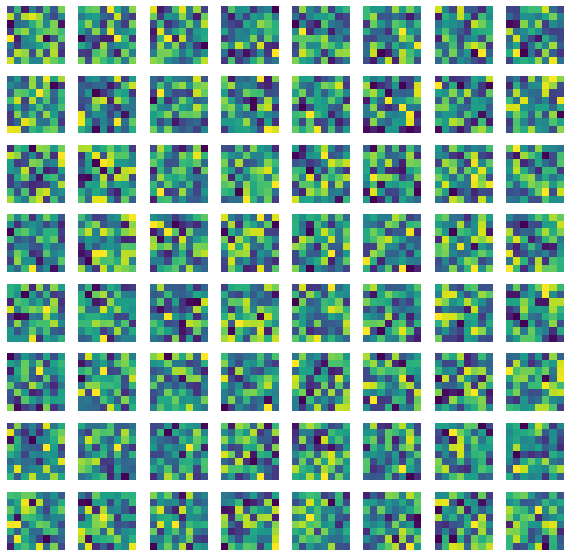

In [22]:
print("Convolutional Filters, Aligned Network, Layer 2")
plt.figure(figsize=(10, 10))
sq = 8
weight = network.conv2.weight.data.cpu().numpy()

for i in range(64):
    plt.subplot(sq, sq, i + 1)
    arr = np.zeros((8,8))
    m = 0
    for j in range(8):
      for k in range(8):
        arr[j][k] = weight[i][m]
        m += 1
    plt.imshow(arr, cmap='viridis')
    plt.axis("off")
plt.show()

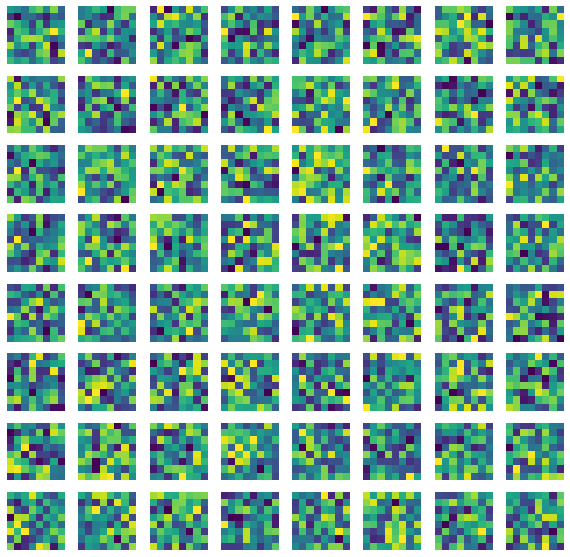

In [23]:
plt.figure(figsize=(10, 10))
sq = 8
weight = network.conv2.weight.data.cpu().numpy()

for i in range(64,128):
    plt.subplot(sq, sq, i -63)
    arr = np.zeros((8,8))
    m = 0
    for j in range(8):
      for k in range(8):
        arr[j][k] = weight[i][m]
        m += 1
    plt.imshow(arr, cmap='viridis')
    plt.axis("off")

plt.show()

Convolutional Filters, Rotated Network, Layer 2


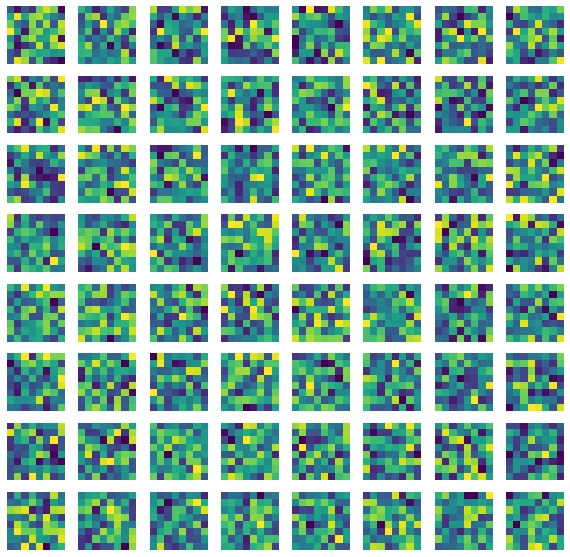

In [24]:
print("Convolutional Filters, Rotated Network, Layer 2")
plt.figure(figsize=(10, 10))
sq = 8
weight = network2.conv2.weight.data.cpu().numpy()

for i in range(64):
    plt.subplot(sq, sq, i + 1)
    arr = np.zeros((8,8))
    m = 0
    for j in range(8):
      for k in range(8):
        arr[j][k] = weight[i][m]
        m += 1
    plt.imshow(arr, cmap='viridis')
    plt.axis("off")
plt.show()

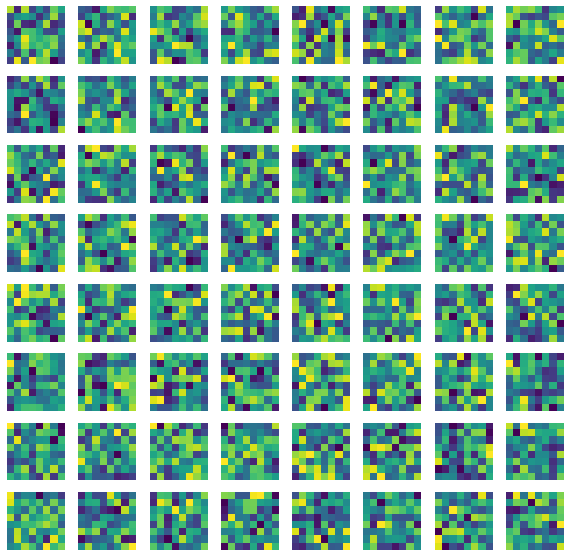

In [25]:
plt.figure(figsize=(10, 10))
sq = 8
weight = network2.conv2.weight.data.cpu().numpy()

for i in range(64,128):
    plt.subplot(sq, sq, i -63)
    arr = np.zeros((8,8))
    m = 0
    for j in range(8):
      for k in range(8):
        arr[j][k] = weight[i][m]
        m += 1
    plt.imshow(arr, cmap='viridis')
    plt.axis("off")

plt.show()

Convolutional Filters, Image Subtraction, Layer 2


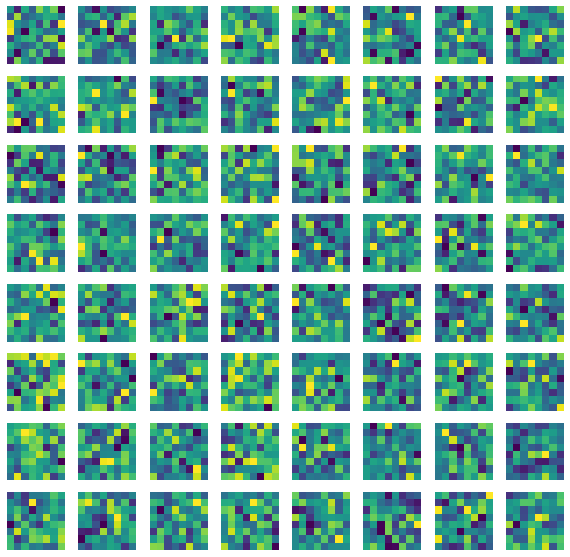

In [26]:
print("Convolutional Filters, Image Subtraction, Layer 2")
plt.figure(figsize=(10, 10))
sq = 8
weight = network.conv2.weight.data.cpu().numpy()
weight2 = network2.conv2.weight.data.cpu().numpy()

for i in range(64):
    plt.subplot(sq, sq, i+1)
    arr = np.zeros((8,8))
    m = 0
    for j in range(8):
      for k in range(8):
        arr[j][k] = weight2[i][m] - weight[i][m]
        m += 1
    plt.imshow(arr, cmap='viridis')
    plt.axis("off")

plt.show()

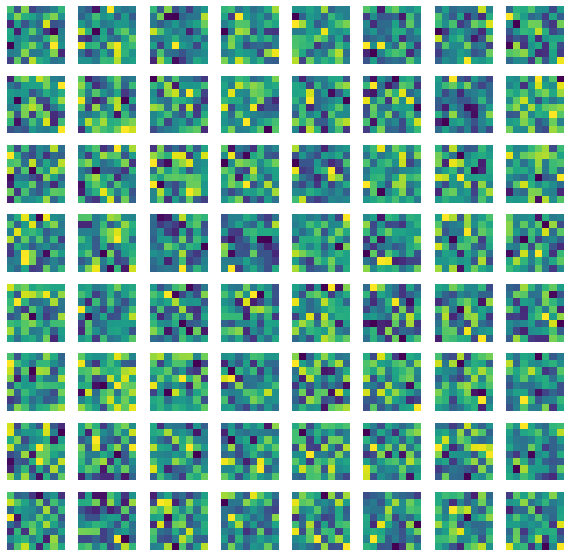

In [27]:
plt.figure(figsize=(10, 10))
sq = 8
weight = network.conv2.weight.data.cpu().numpy()
weight2 = network2.conv2.weight.data.cpu().numpy()

for i in range(64,128):
    plt.subplot(sq, sq, i -63)
    arr = np.zeros((8,8))
    m = 0
    for j in range(8):
      for k in range(8):
        arr[j][k] = weight2[i][m] - weight[i][m]
        m += 1
    plt.imshow(arr, cmap='viridis')
    plt.axis("off")

plt.show()

In [28]:
# plot_weights(network2.cpu(), 1, single_channel = True)

### **Feature Maps**

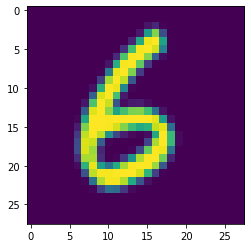

In [31]:
'''
Adapted from https://debuggercafe.com/visualizing-filters-and-feature-maps-in-convolutional-neural-networks-using-pytorch/.
'''

img = cv2.imread("/content/drive/My Drive/six.png", 0)
img = cv2.bitwise_not(img)

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((28, 28)),
    transforms.ToTensor(),
    # transforms.RandomRotation((45,45)),
])
img = np.array(img)

img = transform(img)

plt.imshow(img.squeeze(0))
plt.show()

img = img.unsqueeze(0)

results = [F.relu(F.max_pool2d(network.conv1(img.cuda()), 2))]
results.append(F.relu(F.max_pool2d(network.conv2(results[0]), 2)))

outputs = results

results2 = [F.relu(F.max_pool2d(network2.conv1(img.cuda()), 2))]
results2.append(F.relu(F.max_pool2d(network2.conv2(results2[0]), 2)))

outputs2 = results2

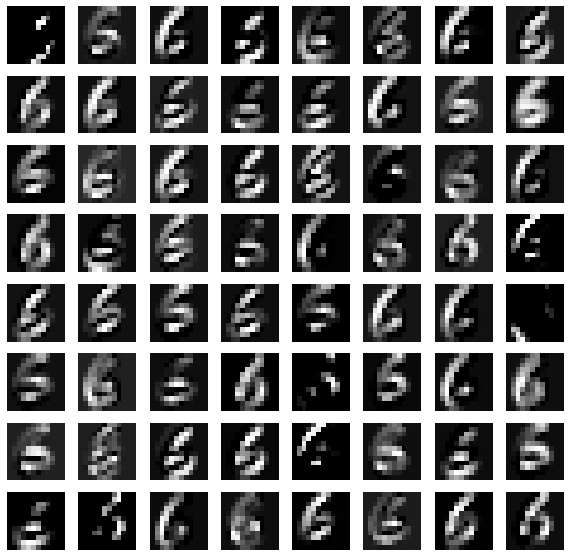

In [34]:
num_layer = 0
plt.figure(figsize=(10, 10))
layer_viz = outputs[num_layer][0, :, :, :]
layer_viz = layer_viz.data

filters = []

n = 64
sq = int(math.sqrt(n))

for i, filter in enumerate(layer_viz):
    plt.subplot(sq, sq, i + 1)
    filters.append(filter)
    plt.imshow(filter.cpu(), cmap='gray')
    plt.axis("off")

plt.show()

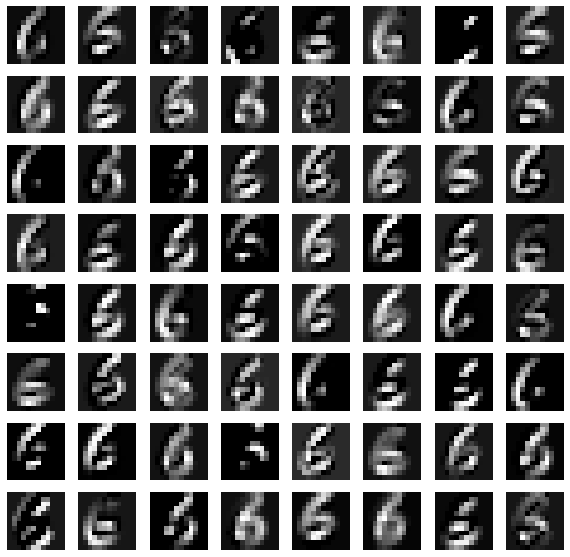

In [35]:
num_layer = 0
plt.figure(figsize=(10, 10))
layer_viz = outputs2[num_layer][0, :, :, :]
layer_viz = layer_viz.data

n = 64
sq = int(math.sqrt(n))

for i, filter in enumerate(layer_viz):
    plt.subplot(sq, sq, i + 1)
    # f = filters[i]
    # save_image(f, 'img1.png')
    # save_image(filter, 'img2.png')
    plt.imshow(filter.cpu(), cmap="gray")
    plt.axis("off")

plt.show()

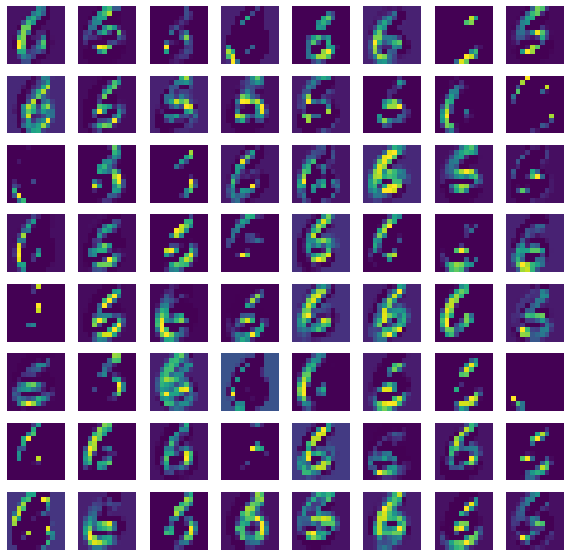

In [36]:
plt.figure(figsize=(10, 10))

for i, filter in enumerate(layer_viz):
    plt.subplot(sq, sq, i + 1)
    f = filters[i]
    save_image(f, 'img1.png')
    save_image(filter.cpu(), 'img2.png')
    plt.imshow(cv2.subtract(cv2.imread('img2.png', cv2.IMREAD_GRAYSCALE),cv2.imread('img1.png', cv2.IMREAD_GRAYSCALE)), cmap='viridis')
    plt.axis("off")

plt.show()

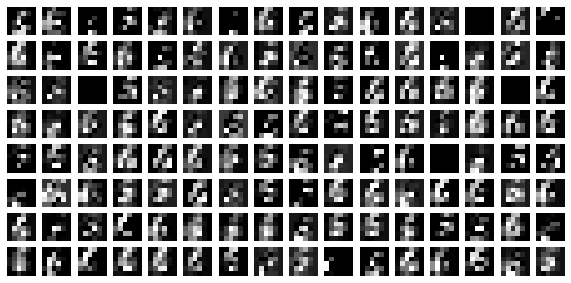

In [37]:
num_layer = 1
plt.figure(figsize=(10, 10))
layer_viz = outputs[num_layer][0, :, :, :]
layer_viz = layer_viz.data

n = 256
sq = int(math.sqrt(n))

for i, filter in enumerate(layer_viz):
    plt.subplot(sq, sq, i + 1)
    plt.imshow(filter.cpu(), cmap='gray')
    plt.axis("off")

plt.show()

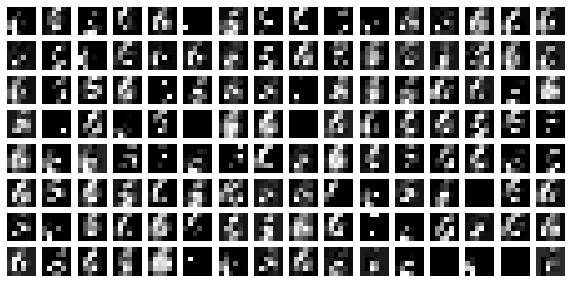

In [38]:
num_layer = 1
plt.figure(figsize=(10, 10))
layer_viz = outputs2[num_layer][0, :, :, :]
layer_viz = layer_viz.data

n = 256
sq = int(math.sqrt(n))

for i, filter in enumerate(layer_viz):
    plt.subplot(sq, sq, i + 1)
    plt.imshow(filter.cpu(), cmap='gray')
    plt.axis("off")

plt.show()

### **Maximum Activation Visualizations**


In [39]:
'''
Adapted from https://discuss.pytorch.org/t/visualize-feature-map/29597.
'''

activation = {}
def get_activation(name):
    def hook(model, input, output):
        activation[name] = output.detach()
    return hook

dataset = torchvision.datasets.MNIST('/files/', train=True, download=True,
                             transform=torchvision.transforms.Compose([
                               torchvision.transforms.ToTensor(),
                              #  torchvision.transforms.RandomRotation((45,45)),
                               torchvision.transforms.Normalize(
                                 (0.5,), (0.5,))
                             ]))

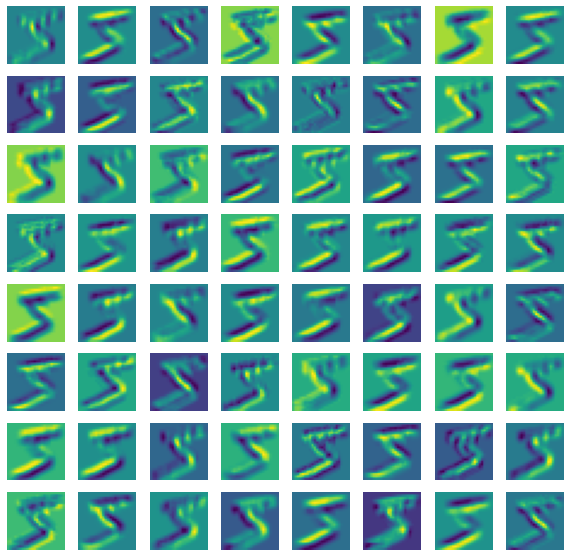

In [42]:
network2.conv1.register_forward_hook(get_activation('conv1'))
data, _ = dataset[0]
data.unsqueeze_(0)
output = network2(data.cuda())

act = activation['conv1'].squeeze()

items = []

n = 64
sq = int(math.sqrt(n))

for idx in range(act.size(0)):
    items.append(act[idx].cpu())

fig, axarr = plt.subplots(sq, sq, figsize=(10,10))
for idx in range(act.size(0)):
    axarr[idx // sq][idx % sq].axis('off')
    axarr[idx // sq][idx % sq].imshow(act[idx].cpu(), cmap='viridis')

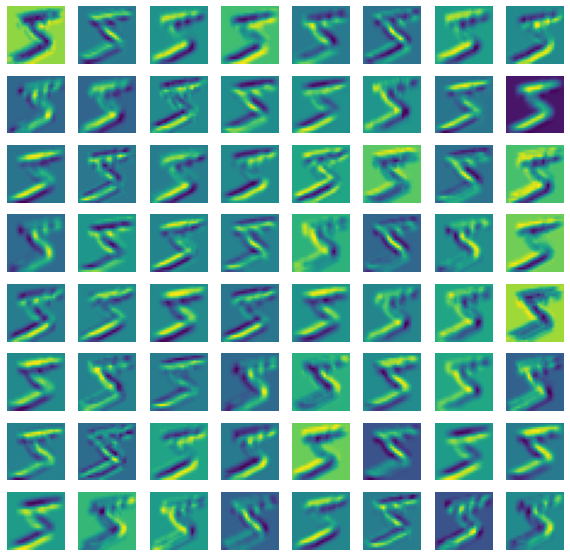

In [43]:
network.conv1.register_forward_hook(get_activation('conv1'))
data, _ = dataset[0]
data.unsqueeze_(0)
output = network(data.cuda())

n = 64
sq = int(math.sqrt(n))

act = activation['conv1'].squeeze()

fig, axarr = plt.subplots(sq, sq, figsize=(10,10))
for idx in range(act.size(0)):
    axarr[idx // sq][idx % sq].axis('off')
    axarr[idx // sq][idx % sq].imshow(act[idx].cpu(), cmap='viridis')

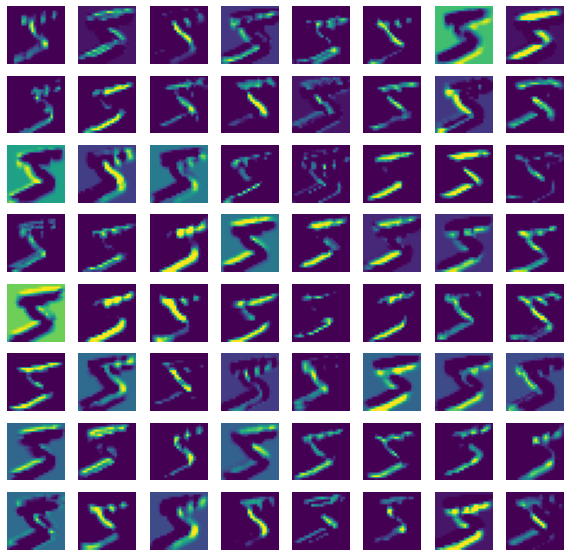

In [44]:
fig, axarr = plt.subplots(sq, sq, figsize=(10,10))
for idx in range(len(items)):
    axarr[idx // sq][idx % sq].axis('off')
    save_image(act[idx], 'img1.png')
    save_image(items[idx], 'img2.png')
    axarr[idx // sq][idx % sq].imshow(cv2.subtract(cv2.imread('img2.png', cv2.IMREAD_GRAYSCALE),cv2.imread('img1.png', cv2.IMREAD_GRAYSCALE)), cmap='viridis')

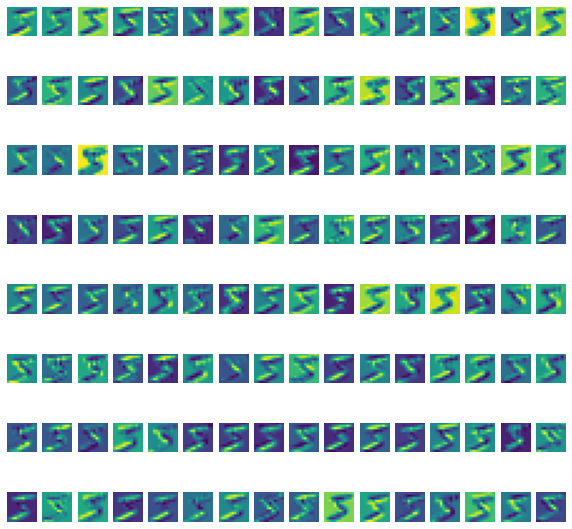

In [45]:
network.conv2.register_forward_hook(get_activation('conv2'))
data, _ = dataset[0]

data.unsqueeze_(0)
output = network(data.cuda())

act = activation['conv2'].squeeze()

n = 128

fig, axarr = plt.subplots(8, 16, figsize=(10,10))
for idx in range(act.size(0)):
    axarr[idx // 16][idx % 16].axis('off')
    axarr[idx // 16][idx % 16].imshow(act[idx].cpu(), cmap='viridis')

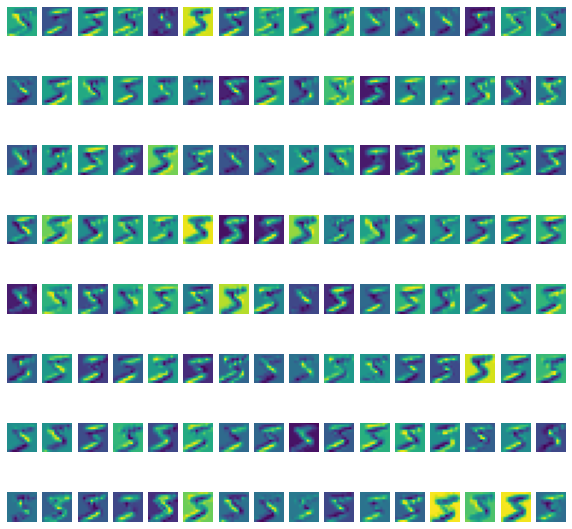

In [46]:
network2.conv2.register_forward_hook(get_activation('conv2'))
data, _ = dataset[0]

data.unsqueeze_(0)
output = network2(data.cuda())

act = activation['conv2'].squeeze()

n = 128

fig, axarr = plt.subplots(8, 16, figsize=(10,10))
for idx in range(act.size(0)):
    axarr[idx // 16][idx % 16].axis('off')
    axarr[idx // 16][idx % 16].imshow(act[idx].cpu(), cmap='viridis')